In [1]:
import os
import numpy as np
import time

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras import layers, callbacks

from keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix

import matplotlib.pyplot as plt

In [2]:
# 제스처 좌표데이터셋 목록 읽어오기
file_list = os.listdir("./Dataset")

# 파일 확장자 빼고 제스처 이름만 저장
actions = []
for i in range(len(file_list)) :
    actions.append(file_list[i][:-4])


# 회전변환 행렬
def Rx(theta) :
    return np.array([[1,        0,              0      ], 
                    [ 0,  np.cos(theta), -np.sin(theta)], 
                    [ 0,  np.sin(theta),  np.cos(theta)]])
def Ry(theta) :
    return np.array([[np.cos(theta),  0,  np.sin(theta)], 
                    [       0,        1,        0      ],
                    [-np.sin(theta),  0,  np.cos(theta)]])
def Rz(theta) :
    return np.array([[np.cos(theta), -np.sin(theta),  0  ], 
                    [ np.sin(theta),  np.cos(theta),  0  ], 
                    [       0,              0,        1  ]])
    
# 각 축을 기준으로 회전변환할 각도 (x, y, z 축 기준 회전각 : pitch, yaw, roll)
rotation_degree_x = np.deg2rad([0, 5,10,20,30, 355,350,340,330])
rotation_degree_y = np.deg2rad([0, 5,10,20,30, 355,350,340,330])
rotation_degree_z = np.deg2rad([0, 30,60,90,120,150,180])


# 시퀀스 길이
seq_length = 10

In [3]:
data_X = np.zeros((1, seq_length, 24))    # 24는 angle데이터 길이
data_Y = np.zeros(1)

# 각 제스처 좌표 데이터셋마다
for action_index, action_name in enumerate(actions):
    loaded = np.load(f'./Dataset/{actions[action_index]}.npy')

    # 각 회전마다
    for rdz in rotation_degree_z :
        for rdy in rotation_degree_y :
            for rdx in rotation_degree_x :
                
                data_list_X, data_list_y = [], []    # 각 회전변환의 리스트 형식의 문제지, 정답지
                angle_data = []
                
                # 제스처데이터 각 프레임마다
                for fr in range(len(loaded)) :
                    coord = []
                    
                    # 각 프레임의 모든 랜드마크 좌표 회전변환
                    for lm in range(21) :    
                        coord.append( loaded[fr][lm] @ Rz(rdz) @ Ry(rdy) @ Rx(rdx) )
                    
                    coord = np.array(coord)

                    a = coord[[ 5,  1,2,3,  5,6,7,   9,10,11,  13,14,15,  17,18,19,  0, 0], :]
                    b = coord[[17,  2,3,4,  6,7,8,  10,11,12,  14,15,16,  18,19,20,  5,17], :] 
                    vec = b - a

                    vec_unit = vec / np.linalg.norm(vec, axis=1)[:, np.newaxis]
                    
                    angle = np.arccos( np.einsum('ij, ij->i',
                        vec_unit[[0,1,2,  0,4,5,  0,7,8,   0,10,11,   0,13,14,  3,6,9,12,15,  6,9,12,15], :], 
                        vec_unit[[1,2,3,  4,5,6,  7,8,9,  10,11,12,  13,14,15,  0,0,0, 0, 0,  2,2, 2, 2], :]))

                    angle_data.append(np.degrees(angle))
                
                # 시퀀스길이에 따라 시퀀스데이터로 변환
                for i in range(len(angle_data) - seq_length):
                    data_list_X.append(angle_data[i: i + seq_length])
                    data_list_y.append(action_index)

                # 문제지, 정답지
                data_X = np.append(data_X, data_list_X, axis=0)
                data_Y = np.append(data_Y, data_list_y, axis=0)

In [4]:
# 문제지,정답지 맨 앞 제외하고
X = data_X[1:]
Y = data_Y[1:]

# 정답지 원핫 인코딩
Y = to_categorical(Y, num_classes=len(actions))

# 훈련데이터 시험데이터 분리
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [5]:
epochs = 20

time_started = time.time()

model = Sequential([
    layers.GRU(64, input_shape = X_train.shape[1:], activation='tanh'),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

checkpoint = callbacks.ModelCheckpoint('./Models/model.h5', save_best_only=True)
earlystopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist = model.fit(   X_train, Y_train,
                    validation_split=0.2,
                    epochs = epochs,
                    callbacks = [checkpoint, earlystopping],
                    verbose=1   )

score = model.evaluate(X_test, Y_test)

time_took = time.time() - time_started

Epoch 1/20
738/738 [==============================] - 4s 4ms/step - loss: 0.3480 - accuracy: 0.8603 - val_loss: 0.0318 - val_accuracy: 1.0000
Epoch 2/20
738/738 [==============================] - 3s 3ms/step - loss: 0.1077 - accuracy: 0.9610 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 3/20
738/738 [==============================] - 2s 3ms/step - loss: 0.1334 - accuracy: 0.9500 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 4/20
738/738 [==============================] - 2s 3ms/step - loss: 0.1190 - accuracy: 0.9524 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 5/20
738/738 [==============================] - 2s 3ms/step - loss: 0.1084 - accuracy: 0.9550 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 6/20
738/738 [==============================] - 2s 3ms/step - loss: 0.1170 - accuracy: 0.9507 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 7/20
738/738 [==============================] - 2s 3ms/step - loss: 0.1250 - accuracy: 0.9481 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 

### 학습 그래프

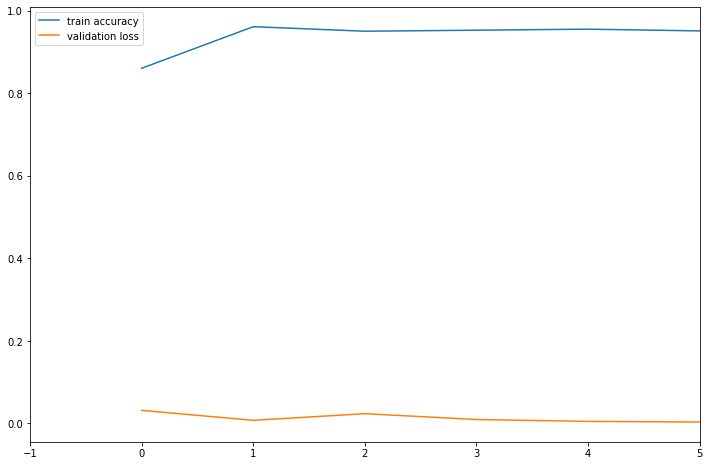

In [6]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_loss'], label='validation loss')

plt.xlim(-1,5)

plt.legend(), plt.grid
plt.show()

### 모델 평가

In [ ]:
model = load_model('models/model.h5')

Y_pred = model.predict(X_test)
Y_pred

In [ ]:
multilabel_confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

### 연습

In [ ]:
loaded = np.load(f'./Dataset/{actions[i]}.npy')
# loaded

In [ ]:
len(loaded)

In [ ]:
loaded[0][0]

In [ ]:
loaded[0][0] @ Rz(np.deg2rad(90)) @ Ry(np.deg2rad(90)) @ Rx(np.deg2rad(90))

In [ ]:
np.dot( np.dot( np.dot( loaded[0][0], Rz(np.deg2rad(90)) ), Ry(np.deg2rad(90)) ), Rx(np.deg2rad(90)) )

In [ ]:
a = loaded[:, [5,   1,2,3,   5,6,7,   9,10,11,   13,14,15,   17,18,19,   0,0], :]
b = loaded[:, [17,   2,3,4,   6,7,8,   10,11,12,   14,15,16,   18,19,20,   5,17], :] 
v = b - a
v.shape, v

In [ ]:
unitv = v / np.linalg.norm(v, axis=2)[:,:,np.newaxis]
unitv.shape, unitv

In [ ]:
# 내적을 이용한 각도 계산 ( a•b = |a||b|cos(Θ) )    # 내적, cos의 역수
angle = np.arccos( np.einsum('ijk, ijk->ij',
                                unitv[:, [0,1,2,  0,4,5,  0,7,8,   0,10,11,    0,13,14,   3,6,9,12,15,   6,9,12,15], :], 
                                unitv[:, [1,2,3,  4,5,6,  7,8,9,  10,11,12,   13,14,15,   0,0,0, 0, 0,   2,2, 2, 2], :]) 
)
angle.shape, angle

In [ ]:
# 라디안 단위 변환
angle = np.degrees(angle)
angle.shape, angle

#### 회전변환, 각도변환

In [ ]:
loaded = np.load(f'./Dataset/{actions[i]}.npy')

In [ ]:
data_X, data_y = [], []

# 각 제스처 좌표데이터별로

# for i, gest in enumerate(actions):
#     loaded = np.load(f'./Dataset/{actions[i]}.npy')

# 회전변환
gest_coord = []
for rdz in rotation_degree_z :
    for rdy in rotation_degree_y :
        for rdx in rotation_degree_x :
            
            for i in range(len(loaded)) :
                frame = []
                for j in range(21) :
                    frame.append( loaded[i][j] @ Rz(rdz) @ Ry(rdy) @ Rx(rdx) )
                    
            gest_coord.append((frame))
            
coord = np.array(gest_coord)

a = coord[:, [ 5,   1,2,3,   5,6,7,    9,10,11,   13,14,15,   17,18,19,   0, 0], :]
b = coord[:, [17,   2,3,4,   6,7,8,   10,11,12,   14,15,16,   18,19,20,   5,17], :] 
v = b - a

unit_v = v / np.linalg.norm(v, axis=2)[:, :, np.newaxis]

angle = np.arccos( np.einsum('ijk, ijk->ij',
                            unit_v[:, [0,1,2,  0,4,5,  0,7,8,   0,10,11,    0,13,14,   3,6,9,12,15,   6,9,12,15], :], 
                            unit_v[:, [1,2,3,  4,5,6,  7,8,9,  10,11,12,   13,14,15,   0,0,0, 0, 0,   2,2, 2, 2], :]) )
angle = np.degrees(angle)

In [ ]:
# gestCoord
# coord.shape, coord
# v.shape, v
# unitv.shape, unitv
angle.shape, angle

### 버전1

In [ ]:
data_X, data_Y = [], []    # 전체 문제지, 정답지

# 각 제스처 좌표 데이터셋마다
for action_index, action_name in enumerate(actions):
    loaded = np.load(f'./Dataset/{actions[action_index]}.npy')

    # 각 회전마다
    for rdz in rotation_degree_z :
        for rdy in rotation_degree_y :
            for rdx in rotation_degree_x :
                
                data_list_X, data_list_y = [], []    # 각 회전변환의 리스트 형식의 문제지, 정답지
                angle_data = []
                
                # 제스처데이터 각 프레임마다
                for fr in range(len(loaded)) :
                    coord = []
                    
                    # 각 프레임의 모든 랜드마크 좌표 회전변환
                    for lm in range(21) :    
                        coord.append( loaded[fr][lm] @ Rz(rdz) @ Ry(rdy) @ Rx(rdx) )
                    
                    coord = np.array(coord)

                    a = coord[[ 5,  1,2,3,  5,6,7,   9,10,11,  13,14,15,  17,18,19,  0, 0], :]
                    b = coord[[17,  2,3,4,  6,7,8,  10,11,12,  14,15,16,  18,19,20,  5,17], :] 
                    vec = b - a

                    vec_unit = vec / np.linalg.norm(vec, axis=1)[:, np.newaxis]
                    
                    angle = np.arccos( np.einsum('ij, ij->i',
                        vec_unit[[0,1,2,  0,4,5,  0,7,8,   0,10,11,   0,13,14,  3,6,9,12,15,  6,9,12,15], :], 
                        vec_unit[[1,2,3,  4,5,6,  7,8,9,  10,11,12,  13,14,15,  0,0,0, 0, 0,  2,2, 2, 2], :]))

                    angle_data.append(np.degrees(angle))
                
                # 시퀀스길이에 따라 시퀀스데이터로 변환
                for i in range(len(angle_data) - seq_length):
                    data_list_X.append(angle_data[i: i + seq_length])
                    data_list_y.append(action_index)
                # 문제지 정답지 타입 변환 - 시간절약
                data_ndarray_X = np.array(data_list_X)
                data_ndarray_y = np.array(data_list_y)
                # 전체 문제지 정답지에 추가 (리스트)
                data_X.append(data_ndarray_X)
                data_Y.append(data_ndarray_y)
                

In [ ]:
# 리스트 타입의 문제지 정답지 ndarray로 타입 변환
data_n_X = np.array(data_X)
data_n_Y = np.array(data_Y)

# ndarray reshape
X = data_n_X.reshape(-1, seq_length, len(angle))
Y = data_n_Y.reshape(-1)

# 정답지 원핫 인코딩
Y = to_categorical(Y, num_classes=len(actions))

# 훈련데이터 시험데이터 분리
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)